# In-Depth: Support Vector Machines
Support Vector Machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()

A Naive Bayes Classifier is a simple model describing the distribution of each underlying class, and uses generative models to probabilistically determine labels for new points (known as *generative classification*). Support Vector Machines use what is called a *discriminative classification*: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

Consider the following classification task with two classes of well-separated points:

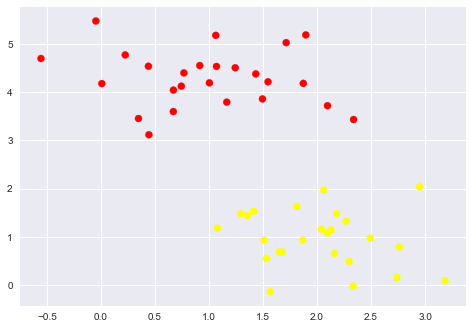

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.6)
plt.scatter(X[:, 0], X[:,1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and create a model for classification. The problem, however, is that there are several possible dividing lines that can perfectly discriminate between the two classes.

Let's draw them:

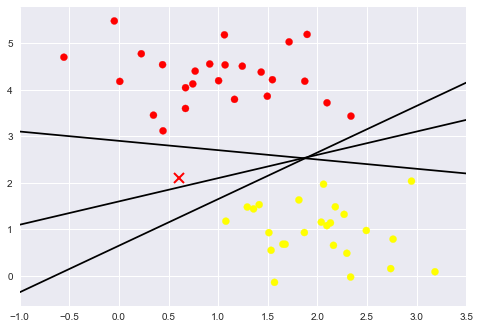

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
    
plt.xlim(-1, 3.5);

## Support Vector Machines: Maximizing the Margin
SVMs offer one way to improve upon the issue above. Rather than drawing a zero-width line between the classes, we can draw a margin of some width around each line. Here is an example of how this would look.

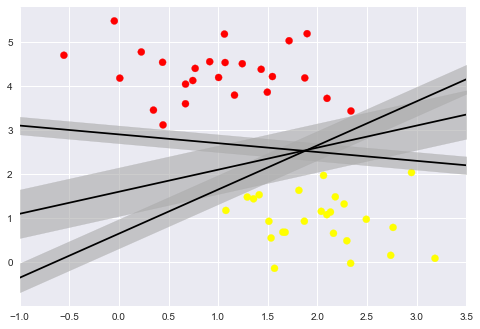

In [7]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.6)
    
plt.xlim(-1, 3.5);

In SVMs, the line that *maximizes* the grey margin is the one we will choose as the optimal model. SVMs are known as a *maximum margin estimator*.

#### Fitting a support vector machine

In [8]:
from sklearn.svm import SVC # Support Vector classifier
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [9]:
# create a function that plots SVM decision boundaries
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a two-dimensional SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Create a grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

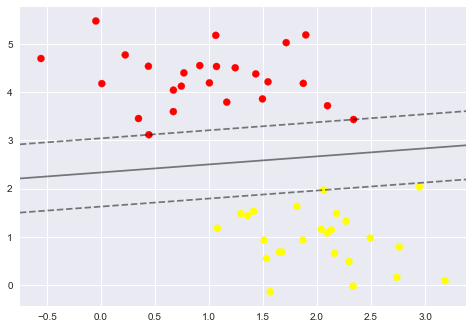

In [10]:
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points. Notice a few training points touch the margin. These points are known as the support vectors. We can identify these points by the following:

In [11]:
model.support_vectors_

array([[ 0.44359863,  3.11530945],
       [ 2.33812285,  3.43116792],
       [ 2.06156753,  1.96918596]])

The key to this classifier's success is that for the fit, only the position of the support vectors matter; any points farther from the margin that are on the correct side do not modify the fit. This is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter as long as they don't cross the margin.

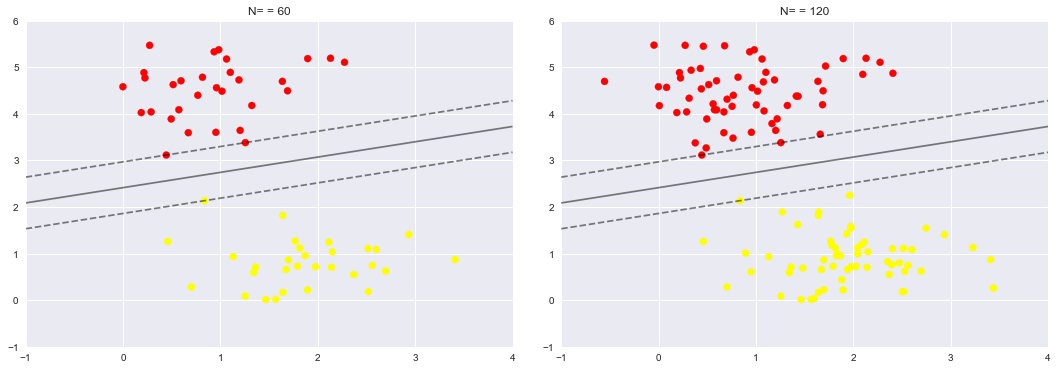

In [12]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)
    
fig, ax = plt.subplots(1, 2, figsize=(16,6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N= = {0}'.format(N))

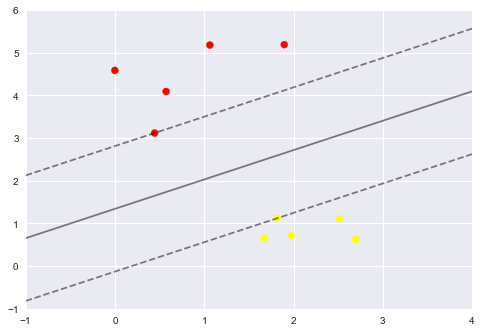

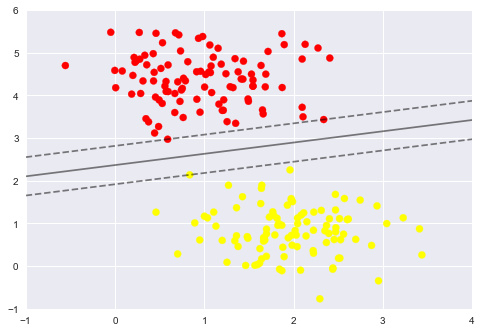

In [14]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

#### Beyond linear boundaries: Kernel SVM
SVM becomes extremely powerful when combined with **kernels**. Kernels can be seen when using Linear Regression models. When we project our data into higher-dimensional space defined by polynomials and Gaussian basis functions, we were able to fit nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea. Let's look at an example of non-linearly separable data:

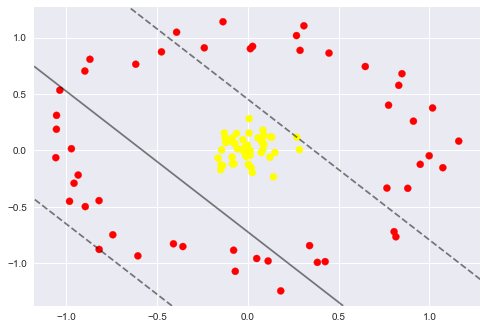

In [15]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=0.1, noise=0.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It's clear no linear discrimination will ever be able to separate this data. We can, however, project the data into a higher dimension such that a linear separator would be sufficient. For example, one projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [16]:
r = np.exp(-(X**2).sum(1))

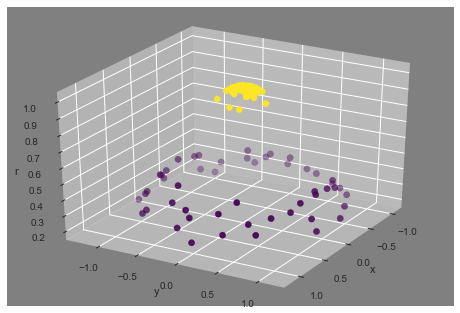

In [61]:
ax = plt.axes(projection='3d', facecolor='grey')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=40, cmap='viridis')
ax.view_init(elev=30, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r')

Adding an extra dimension, we can see the data becomes trivially linearly separable, by drawing a separating plane at around, say, r=0.6. 

If we had not centered our radial basis function in this right location, we would not have seen such clean, linearly separable results. Choosing the proper function is difficult: it would be great to somehow automatically find the best basis function to use.

One strategy would be to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results. This is known as *kernel transformation*. A potential problem with this strategy is that it might become very computationally intensive as the number of points grows large. However, because of a neat process known as the ***kernel trick***, a fit on kernel-transformed data can be done implicitly without ever needing to compute a basis function centered at every point.

We can apply a kernelized SVM bu changing our linear kernel to an RBF (radial basis function) kernel.

In [62]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

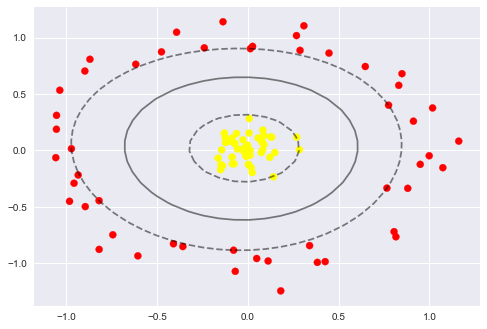

In [63]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

#### Tuning the SVM: Softening margins
What do we do if our dataset has overlapping points and isn't so clean? For example, we may have data like this:

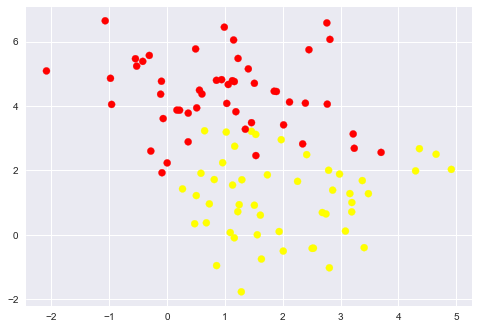

In [64]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='autumn');

To handle this, SVM has a bit of a fudge-factor that "softens" the margin, which essentially allows some of the points to creep into the margin if it allows a better fit. The hardness of the margin is controlled by a tuning parameter, C. For a large C, the margin is hard and won't allow points to lie in it. For a small C, the margin is softer and allows some points.

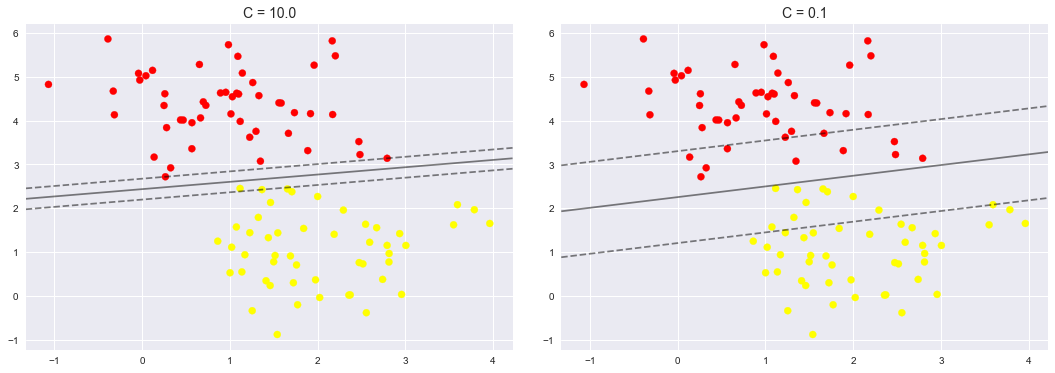

In [65]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:,0], X[:,1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:,0],
                model.support_vectors_[:,1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

## Example: Face Recognition

In [66]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print faces.target_names
print faces.images.shape

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


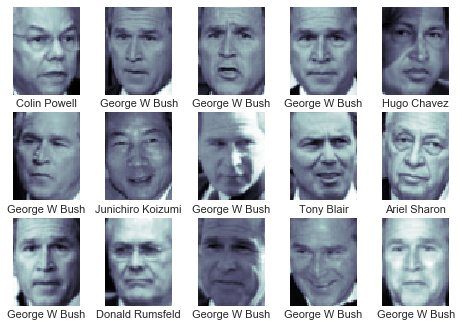

In [67]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Each image is 62x47 pixels (~3000 pixels per image). We will use Principal Component Analysis (PCA) to extract 150 fundamental components to feed into our SVM classifier.

In [72]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [73]:
pca = PCA(svd_solver='randomized', n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [75]:
# split data into training and testing
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

In [78]:
# use grid search cross validation to explore combinations of parameters
# C controls margin hardness
# gamma controls size of radial basis function kernel
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print grid.best_params_

CPU times: user 1min 19s, sys: 2.6 s, total: 1min 22s
Wall time: 51 s
{'svc__gamma': 0.001, 'svc__C': 10}


The optimal parameters fell in the middle of our grid. If they fell on the edge, we would want to expand our grid parameters. Now we can predict labels for the test data.

In [79]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

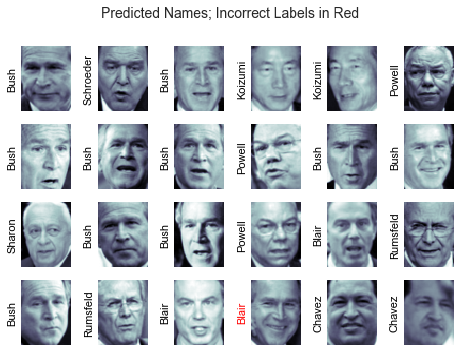

In [80]:
# Let's view a few images with their predictions
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [81]:
from sklearn.metrics import classification_report
print classification_report(ytest, yfit, target_names=faces.target_names)

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

      avg / total       0.86      0.85      0.85       337



/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


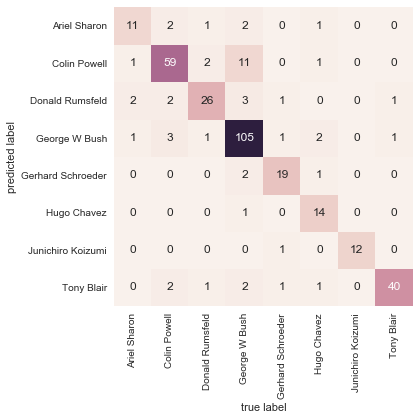

In [82]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Support Vector Machine Summary

Support Vector Machines are a powerful classification method for a number of reasons:

 - Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
 - Once the model is trained, the prediction phase is very fast.
 - Because they are affected only by points near the margin, they work well with high-dimensional data - even data with more dimensions than samples, which is a challenging regime for other algorithms.
 - Their integration with kernel methods makes them very versatile, able to adapt to many types of data.
 
However, SVMs have several disadvantages as well:

 - The scaling with the number of samples N is O[$N^3$] at worst, or O[$N^2$] for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
 - The results are strongly dependent on a suitable choice for the softening parameter C. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
 - The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation, but this extra estimation is costly.
 
With those traits in mind, it is common to turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient.